In [1]:
import numpy as np
import pandas as pd
from gensim import matutils, corpora
import pickle

In [2]:
with open('acts_filtered_LDA_models.pkl', 'rb') as f:
    acts_filtered_LDA_models = pickle.load(f)

with open('acts_filtered_corpus.pkl', 'rb') as f:
    acts_filtered_corpus = pickle.load(f)

with open('../../Acts/processed_acts.pkl', 'rb') as f:
    processed_acts = pickle.load(f)

acts_filtered_dictionary = corpora.Dictionary.load('acts_filtered_dictionary.gensim')

In [3]:
acts24_filtered_model = acts_filtered_LDA_models[24]
acts21_filtered_model = acts_filtered_LDA_models[21]
acts9_filtered_model = acts_filtered_LDA_models[9]


In [4]:
def _safe_tokens(model):
    id2word = model.id2word
    i2t = getattr(id2word, "id2token", None)
    if i2t is None:
        inv = {v: k for k, v in id2word.token2id.items()}
        def tok(i): return inv.get(int(i))
    elif isinstance(i2t, dict):
        def tok(i): return i2t.get(int(i))
    else:
        def tok(i):
            i = int(i)
            return i2t[i] if 0 <= i < len(i2t) else None
    return tok

def _background_pw_from_corpus(corpus, V):
    csc = matutils.corpus2csc(corpus, num_terms=V)
    tf = np.asarray(csc.sum(axis=1)).ravel().astype(float)
    tf[tf == 0.0] = 1e-12
    return tf / tf.sum()

def _lambda_relevance_order_indices(phi_k, p_w, lam=0.6, topn=None):
    log_beta = np.log(np.clip(phi_k, 1e-12, None))
    rel = lam * log_beta + (1 - lam) * (log_beta - np.log(np.clip(p_w, 1e-12, None)))
    order = np.argsort(-rel)
    if topn is not None:
        order = order[:topn]
    return order

# Calculating Best Number of Keywords per Topic

## Option: Coverage Threshold Method

### Get median number of keywords for median elbow coverage
1. Compute per-topic cumulative coverage curves
2. Find an elbow (knee) for each topic via "max distance from diagonal" heuristic
3. summarize elbow rank and cumulative coverage probability
4. get median elbow coverage across topics

In [5]:


def topic_cumulative_coverages(model, corpus=None, order="beta", lam=0.6, topn=None):
    phi = model.get_topics()
    K, V = phi.shape
    tok = _safe_tokens(model)
    p_w = None
    if order == "relevance":
        if corpus is None:
            raise ValueError("order='relevance' requires `corpus` to compute p(w)`.")
        p_w = _background_pw_from_corpus(corpus, V)

    results = []
    for k in range(K):
        beta_k = phi[k].copy()
        if order == "beta":
            idx = np.argsort(-beta_k)
        elif order == "relevance":
            idx = _lambda_relevance_order_indices(beta_k, p_w, lam=lam, topn=topn)
        else:
            raise ValueError("order must be 'beta' or 'relevance'")
        if topn is not None and order == "beta":
            idx = idx[:topn]

        betas_sorted = beta_k[idx]
        cum = np.cumsum(betas_sorted)
        cum = cum / cum[-1]
        tokens = [tok(i) for i in idx]
        ranks = np.arange(1, len(idx) + 1)
        results.append({
            "topic": k,
            "ranks": ranks,
            "tokens": tokens,
            "betas": betas_sorted,
            "cum": cum
        })
    return results

def knee_index_from_curve(cum):
    n = len(cum)
    if n == 0:
        return None
    x = np.arange(1, n + 1) / n
    dist = cum - x
    return int(np.argmax(dist))

def summarize_elbows_df(model, corpus=None, order="beta", lam=0.6, topn=None):
    curves = topic_cumulative_coverages(model, corpus=corpus, order=order, lam=lam, topn=topn)
    data = []
    for R in curves:
        idx = knee_index_from_curve(R["cum"])
        if idx is None:
            continue
        mstar = idx + 1  # 1-based
        cov = float(R["cum"][idx])
        top_tokens = R["tokens"][:mstar]
        data.append({
            "Topic": R["topic"],
            "Elbow_Rank": mstar,
            "Coverage_at_Elbow": cov,
            "Top_Words_to_Elbow": ", ".join(top_tokens)
        })

    df = pd.DataFrame(data)
    median_cov = df["Coverage_at_Elbow"].median()
    median_rank = int(df["Elbow_Rank"].median())
    print(f"Median coverage at elbow: {median_cov:.4f}")
    print(f"Median number of words at elbow: {median_rank}")
    return df, median_cov, median_rank


In [6]:
df_elbows_rel, median_cov_rel, median_rank_rel = summarize_elbows_df(
    acts24_filtered_model, corpus=acts_filtered_corpus, order="relevance", lam=0.6
)

Median coverage at elbow: 0.8315
Median number of words at elbow: 357


### Plotting Topic Elbows

In [15]:
import matplotlib.pyplot as plt

def plot_elbow_for_topics(model, corpus=None, topics=(0, 1, 2), order="beta", lam=0.6, topn=None):
    """
    Plot cumulative-token coverage curves for selected topics and mark the 'elbow' (knee).
    Uses topic_cumulative_coverages() and knee_index_from_curve() helpers.

    Args:
        model: gensim LdaModel (already trained).
        corpus: iterable of bow docs (needed if order='relevance').
        topics: iterable of topic indices to plot.
        order: 'beta' or 'relevance' (matches helper).
        lam: lambda for relevance (ignored if order='beta').
        topn: optionally cap the vocab rank (e.g., 200) for a tighter x-range.
    """
    # Compute curves just once
    curves = topic_cumulative_coverages(
        model, corpus=corpus, order=order, lam=lam, topn=topn
    )

    for t in topics:
        R = curves[t]
        cum = R["cum"]
        n = len(cum)
        if n == 0:
            print(f"[warn] topic {t}: empty curve")
            continue

        # Elbow
        knee = knee_index_from_curve(cum)  # 0-based
        mstar = knee + 1
        cov = float(cum[knee])

        # Baseline diagonal (uniform mass)
        x = np.arange(1, n + 1)
        baseline = x / n

        # Plot (one figure per topic)
        plt.figure()
        plt.plot(x, cum, label="Cumulative coverage")
        plt.plot(x, baseline, linestyle="--", label="Uniform baseline")
        plt.scatter([mstar], [cov])  # elbow point
        plt.axvline(mstar, linestyle=":", linewidth=1)
        plt.title(f"Topic {t} — elbow at rank {mstar} (coverage={cov:.3f})")
        plt.xlabel("Rank within topic")
        plt.ylabel("Cumulative probability")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Optional: quick peek at the elbow words
        elbow_tokens = R["tokens"][:mstar]
        print(f"Topic {t}: elbow rank={mstar}, coverage={cov:.3f}")
        print("  Top words to elbow:", ", ".join(elbow_tokens))



In [16]:
# Example usage:
# plot_elbow_for_topics(acts24_filtered_model, corpus=acts_filtered_corpus, topics=(0,1,2), order="beta", topn=None)

In [17]:
V = len(acts_filtered_model.id2word)
print("Vocabulary size:", V)


NameError: name 'acts_filtered_model' is not defined

### Plotting the median elbow

In [ ]:
def plot_median_elbow(model, corpus=None, order="beta", lam=0.6, topn=None, show_hist=True):
    """
    Plot the median cumulative-coverage curve across topics and mark the median elbow.
    - Uses topic_cumulative_coverages() for per-topic curves.
    - Uses summarize_elbows_df() to get the median elbow rank & coverage.
    - 'topn' caps how many ranks to include when aggregating the median curve.
    """
    # 1) Per-topic curves
    curves = topic_cumulative_coverages(
        model, corpus=corpus, order=order, lam=lam, topn=topn
    )
    if not curves:
        print("[warn] No topic curves found.")
        return

    # 2) Build aligned matrix of cumulative curves (truncate to common length L)
    lengths = [len(R["cum"]) for R in curves]
    L = min(lengths) if topn is None else min(min(lengths), topn)
    if L == 0:
        print("[warn] Curves have zero length.")
        return

    cum_mat = np.vstack([R["cum"][:L] for R in curves])
    median_curve = np.median(cum_mat, axis=0)

    # 3) Compute median elbow stats from your helper (robust to differing lengths)
    df, median_cov, median_rank = summarize_elbows_df(
        model, corpus=corpus, order=order, lam=lam, topn=topn
    )

    # 4) Make the plot
    x = np.arange(1, L + 1)
    baseline = x / L

    plt.figure()
    plt.plot(x, median_curve, label="Median cumulative coverage")
    plt.plot(x, baseline, linestyle="--", label="Uniform baseline")

    # Mark the median elbow if it lies within the plotted range
    if 1 <= median_rank <= L:
        plt.scatter([median_rank], [median_cov])
        plt.axvline(median_rank, linestyle=":", linewidth=1)
        plt.title(f"Median elbow at rank {median_rank} (coverage={median_cov:.3f})")
    else:
        plt.title("Median cumulative coverage (median elbow outside plotted range)")

    plt.xlabel("Rank within topic")
    plt.ylabel("Cumulative probability")
    plt.legend()
    plt.tight_layout()
    plt.savefig("../../figures/act_figures/acts_median_elbow.png", dpi=300)
    plt.show()


Median coverage at elbow: 0.8239
Median number of words at elbow: 515


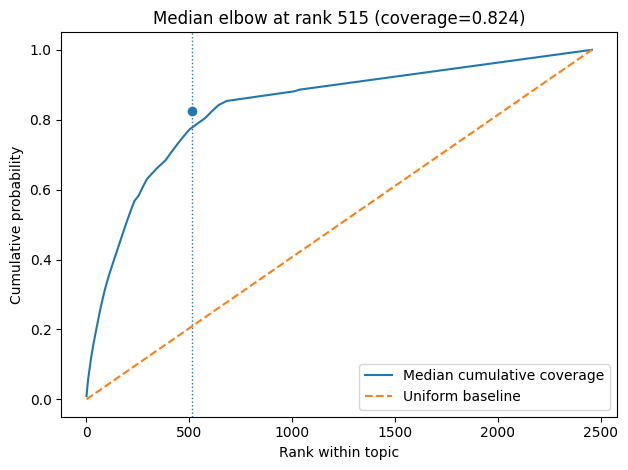

In [ ]:
# Example usage:    
# plot_median_elbow(
#    acts24_filtered_model,
#    corpus=None,
#    order="beta",
#    topn=None
#)


## Option: Marginal-Gain Elbow (instead of Coverage Threshold)
Median coverage at elbow was around 80% for both lamba-ordered and beta-ordered keywords, and the median number of keywords was 400+ for both. Instead, we can try a derivative rather than cumulative method. 

Instead of trying for a cumulative coverage of 80% (which may mean hundreds of words for diffuse topics or less for peaked topics), we can say "I want to stop only when the next word increases coverage by, say, less than 0.1% of what's left." 

With this method, we choose m* via marginal gain, and then report whatever coverage that m* happens to achieve


### Marginal-Gain Elbow (Absolute tau value )


In [16]:
def choose_m_by_marginal_gain(betas_sorted, min_m=1, max_m=None, tau=0.001):
    """
    Stop at first m >= min_m where the next word's contribution to the *remaining* mass
    is less than tau. Clamp to [min_m, max_m].
    gain_m = beta_m / (1 - cumulative_{m-1})
    """
    if max_m is None:
        max_m = len(betas_sorted)
    cum = 0.0
    m_star = min_m
    for m, b in enumerate(betas_sorted, start=1):
        if m > max_m: break
        rem = max(1.0 - cum, 1e-12)
        gain = b / rem
        cum += b
        if m >= min_m and gain < tau:
            m_star = m
            break
        m_star = min(m, max_m)
    coverage = float(np.sum(betas_sorted[:m_star]))
    return m_star, coverage

def summarize_keywords_df(
    model,
    corpus=None,
    lam=0.6,
    min_m=1,
    max_m=None,
    tau=0.001,
    restrict_beta_cover=0.95  # e.g., 0.95 to limit knee search to effective subset
):
    """
    1) Sort tokens by β (probability) to get a stable mass curve.
    2) Optionally restrict to first 'restrict_beta_cover' (e.g., 0.95) coverage in β-order.
    3) Choose m* via marginal-gain rule (tau), clamped to [min_m, max_m].
    4) Display the top m* tokens by λ-relevance (lam=0.6), but we still *sum β*.
    Returns: (df, median_coverage, median_m)
    """
    phi = model.get_topics()        # (K, V), β = p(w|k)
    K, V = phi.shape
    tok = _safe_tokens(model)

    p_w = None
    if corpus is not None:
        p_w = _background_pw_from_corpus(corpus, V)

    rows, covs, ms = [], [], []

    for k in range(K):
        beta_k = phi[k].copy()

        # β-order indices
        idx_beta = np.argsort(-beta_k)
        betas_sorted_full = beta_k[idx_beta]
        # restrict to effective subset if requested
        if restrict_beta_cover is not None:
            cum = np.cumsum(betas_sorted_full)
            cum /= cum[-1]
            cutoff = int(np.searchsorted(cum, restrict_beta_cover)) + 1
            idx_eff = idx_beta[:cutoff]
            betas_sorted = beta_k[idx_eff]
            idx_beta_used = idx_eff
        else:
            betas_sorted = betas_sorted_full
            idx_beta_used = idx_beta

        # Decide m* by marginal gain on β-order curve
        m_star, cov_star = choose_m_by_marginal_gain(
            betas_sorted, min_m=min_m, max_m=max_m, tau=tau
        )

        # For display, reorder by λ-relevance and take top m*
        if p_w is not None:
            idx_rel_all = _lambda_relevance_order_indices(beta_k, p_w, lam=lam)
            tokens_rel = [tok(i) for i in idx_rel_all[:m_star]]
        else:
            # fall back to β-order for display if p(w) unavailable
            tokens_rel = [tok(i) for i in idx_beta_used[:m_star]]

        rows.append({
            "Topic": k,
            "Words_per_Topic": m_star,
            "Coverage_using_Beta": cov_star,
            "Top_Words_RelevanceOrder": ", ".join([t for t in tokens_rel if t is not None])
        })
        covs.append(cov_star)
        ms.append(m_star)

    df = pd.DataFrame(rows)
    med_cov = float(np.median(covs))
    med_m = int(np.median(ms))
    print(f"Median coverage (β-based): {med_cov:.8f}")
    print(f"Median words per topic: {med_m}")
    return df, med_cov, med_m

In [17]:
df, med_cov, med_m = summarize_keywords_df(
    acts21_filtered_model,
    corpus=acts_filtered_corpus,  # for λ-relevance display
    lam=0.6,
    min_m=1,
    max_m=None,
    tau=0.001,                    # increase if lists feel long; decrease if too short
    restrict_beta_cover=0.95     # optional: only search knee within 95% β coverage
)

print(df.head())

Median coverage (β-based): 0.87896121
Median words per topic: 420
   Topic  Words_per_Topic  Coverage_using_Beta  \
0      0              435             0.878961   
1      1              132             0.564622   
2      2              569             0.905199   
3      3              420             0.882376   
4      4              225             0.774369   

                            Top_Words_RelevanceOrder  
0  lis, homo, tyrannus, subicio, finis, error, ui...  
1  suscito, abstineo, princeps, uiolentum, udus, ...  
2  sentio, insuetus, coerceo, biga, insulto, reme...  
3  spiro, iudex, classis, leuo, uinum, tuba, sors...  
4  nupta, nurus, altrix, cognatus, neo, famula, a...  


In [ ]:
def preview_gains(model, k, top=50):
    phi = model.get_topics()
    beta = np.sort(phi[k])[::-1][:top]
    cum = np.cumsum(beta)
    gains = beta / np.maximum(1.0 - np.concatenate(([0.0], cum[:-1])), 1e-12)
    return list(zip(range(1, top+1), beta, gains))

# Example:
for i, b, g in preview_gains(acts21_filtered_model, k=0, top=20):
    print(f"rank={i:2d} beta={b:.6f} gain={g:.6f}")


rank= 1 beta=0.010819 gain=0.010819
rank= 2 beta=0.010035 gain=0.010145
rank= 3 beta=0.009850 gain=0.010060
rank= 4 beta=0.009635 gain=0.009940
rank= 5 beta=0.008398 gain=0.008751
rank= 6 beta=0.007565 gain=0.007952
rank= 7 beta=0.006991 gain=0.007408
rank= 8 beta=0.006877 gain=0.007342
rank= 9 beta=0.006486 gain=0.006976
rank=10 beta=0.006298 gain=0.006821
rank=11 beta=0.005972 gain=0.006512
rank=12 beta=0.005230 gain=0.005740
rank=13 beta=0.005125 gain=0.005657
rank=14 beta=0.005100 gain=0.005662
rank=15 beta=0.005063 gain=0.005654
rank=16 beta=0.005063 gain=0.005685
rank=17 beta=0.004938 gain=0.005576
rank=18 beta=0.004785 gain=0.005434
rank=19 beta=0.004668 gain=0.005331
rank=20 beta=0.004600 gain=0.005280


### Marginal-Gain Elbow by relative drop cutoff
Since the beta values are tiny, the tau values have to be tiny as well. We need hundreds of words per topic to get ~0.55 coverage. With 10-12 words, the coverage will be low (~0.06). We could make tau values topic-scaled instead of absolute
- compute gains down the beta-sorted or lambda-sorted list
- Find where gain reaches its early peak (local maximum)
- Since our vocabulary is 2457 words, we need to find the global maximum of gains within the first N ranks to get the highest gain in the early region
- N is the window in which the early structure of the topic lives, so N should be:
    - big enough that it contains the head and the plateau (the meaninful "core" region)
    - small enough so that it's not dominated by the flat tail/where gains are microscopic
- We test with N = 5% of vocabularly, but clamped between ~30 and 150
- Extend the "plateau" forward---as long as gains stay within 95% of the peak value, we can call that the plateau
- When the gain drops below 95% of the peak, we've found the end of the plateau
- We use the average gain in that plateau as a reference for our adaptive threshold (α) (e.g. α x gain_ref)
- Now we stop when the marginal contribution of a new word has dropped below x% of what it was around the word at gain_ref


#### For beta-ordered keywords

In [12]:
def choose_m_by_relative_drop(betas_sorted, min_m=1, max_m=None, alpha=0.85, peak_drop=0.95):
    """
    betas_sorted: β sorted descending for one topic
    alpha: factor for adaptive elbow later (e.g. 0.85)
    peak_drop: fraction of peak to define plateau end (e.g. 0.95)

    Returns:
        m_star : index of cutoff
        coverage : sum of β up to m_star
    """
    V_subset = len(betas_sorted)
    # 1. Compute gains
    gains = []
    cum = 0.0
    for b in betas_sorted:
        rem = max(1.0 - cum, 1e-12)
        gains.append(b / rem)
        cum += b
    gains = np.array(gains)
    

    # 2. Define an "early region" N ≈ 5% of vocab, clamped
    N = min(150, max(30, V_subset // 20))

    # 3. Find highest gain in that early region (global max within [0:N))
    peak_idx = int(np.argmax(gains[:N]))
    peak_gain = gains[peak_idx]

    # 4. Extend plateau forward while gains stay within 95% of peak
    plateau_threshold = peak_drop * peak_gain  # e.g. 0.95 * peak
    plateau_end = peak_idx + 1  # inclusive index + 1

    for i in range(peak_idx + 1, V_subset):
        if gains[i] >= plateau_threshold:
            plateau_end = i + 1  # keep extending
        else:
            break

    # 5. Mean gain over plateau as reference
    gain_ref = float(np.mean(gains[peak_idx:plateau_end]))
    elbow_threshold = alpha * gain_ref

    # Debug prints
    
    # print("V:", V_subset)
    # print("N:", N)
    # print("peak_idx:", peak_idx, "peak_gain:", peak_gain)
    # print("plateau_end:", plateau_end)
    # print("gain_ref:", gain_ref, "elbow_threshold:", elbow_threshold)
    # print("first 10 gains:", gains[:10])

    # 6. Stop when gain < α * gain_ref
    m_star = V_subset
    for m, g in enumerate(gains, start=1):
        if g < elbow_threshold and m >= min_m:
            m_star = m
            break
    if max_m is not None:
        m_star = min(m_star, max_m)
    coverage = float(np.sum(betas_sorted[:m_star]))
    return m_star, coverage

    
def summarize_keywords_df_adaptive(
    model,
    corpus,
    lam=0.6,
    min_m=10,
    max_m=None,
    alpha=0.85,             # relative drop factor (for elbow)
    restrict_beta_cover=0.95,
    peak_drop=0.95  # limit gain computation to effective subset
):
    """
    Summarize topics using an adaptive marginal-gain elbow:

      • Compute β for each topic (model.get_topics()).
      • Restrict to the part of the β-curve that covers `restrict_beta_cover`
        of the mass (β-order), to avoid ultra-long tails in knee search.
      • On that subset, choose m* via choose_m_by_relative_drop (adaptive elbow).
      • Display top m* words in β-order (topic-word probability order).

    Returns:
      df, median_coverage, median_m
    """
    phi = model.get_topics()      # (K, V)
    K, V = phi.shape
    tok = _safe_tokens(model)
    p_w = _background_pw_from_corpus(corpus, V)

    rows, covs, ms = [], [], []

    for k in range(K):
        beta_k = phi[k].copy()

        # β-order indices
        idx_beta = np.argsort(-beta_k)
        betas_sorted_full = beta_k[idx_beta]

        # Restrict to effective subset for knee detection (optional)
        if restrict_beta_cover is not None:
            cum = np.cumsum(betas_sorted_full)
            cum /= cum[-1]  # normalize to [0,1]
            cutoff = int(np.searchsorted(cum, restrict_beta_cover)) + 1
            cutoff = min(cutoff, len(betas_sorted_full))
            idx_eff = idx_beta[:cutoff]
            betas_sorted = beta_k[idx_eff]
        else:
            betas_sorted = betas_sorted_full

        # Decide m* via adaptive relative-drop rule on β-order curve
        m_star, cov_star = choose_m_by_relative_drop(
            betas_sorted,
            min_m=min_m,
            max_m=max_m,
            alpha=alpha,
            peak_drop=peak_drop
        )

        # For display: reorder vocabulary by λ-relevance and take top m*
        # idx_rel_all = _lambda_relevance_order_indices(beta_k, p_w, lam=lam)
        # words_rel = [tok(i) for i in idx_rel_all[:m_star] if tok(i) is not None]

        words_beta = [tok(i) for i in idx_eff[:m_star] if tok(i) is not None]


        rows.append({
            "Topic": k,
            "Words_per_Topic": m_star,
            "Coverage_using_Beta": cov_star,
            "Top_Words": ", ".join(words_beta),
        })
        covs.append(cov_star)
        ms.append(m_star)

    df = pd.DataFrame(rows)
    med_cov = float(np.median(covs))
    med_m = int(np.median(ms))
    print(f"Median coverage (β-based): {med_cov:.3f}")
    print(f"Median words per topic: {med_m}")

    return df, med_cov, med_m


In [17]:
df, med_cov, med_m = summarize_keywords_df_adaptive(
    acts24_filtered_model,
    acts_filtered_corpus,
    lam=0.6,
    min_m=8,
    max_m=None,
    alpha=0.55,             
    restrict_beta_cover=1,
    peak_drop=0.80
)
print(df.head())

Median coverage (β-based): 0.079
Median words per topic: 9
   Topic  Words_per_Topic  Coverage_using_Beta  \
0      0               16             0.148504   
1      1               14             0.082386   
2      2                8             0.043955   
3      3                8             0.056088   
4      4               25             0.262335   

                                           Top_Words  
0  princeps, misero, inuideo, ratis, soror, pieta...  
1  orbis, dexter, horridus, uiuo, gnatus, moror, ...  
2  currus, nefandus, facinus, geminus, fluctus, c...  
3  ratis, grex, pelagus, fretum, sors, classis, f...  
4  nurus, amo, bruma, altrix, diligo, opto, scind...  
